In [73]:
import pandas as pd
import numpy as np

#Visualization
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
from collections import Counter

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

from numpy import array

from sklearn.feature_extraction.text import CountVectorizer

# Word2vec
import gensim

In [74]:
path = "./data/Sentiment140.tenPercent.sample.tweets.csv"

In [75]:
df = pd.read_csv(path, sep="\t", on_bad_lines='skip', encoding = "ISO-8859-1") 
df.head()

,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


In [76]:
print(df.columns)
print(df.isna().sum())
print(df.shape)

Index(['sentiment_label', 'tweet_text'], dtype='object')
sentiment_label    0
tweet_text         0
dtype: int64
(160000, 2)


In [77]:
df["tweet_text"][3]

'@vaLewee I know!  Saw it on the news!'

<AxesSubplot: xlabel='sentiment_label', ylabel='count'>

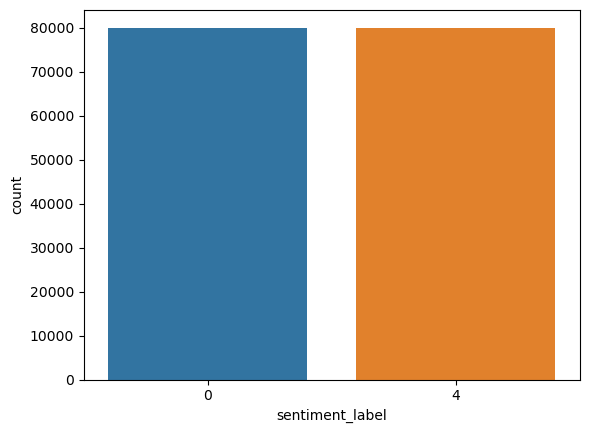

In [78]:
sns.countplot(x='sentiment_label', data=df)

In [79]:
decode_map = {0: "NEGATIVE", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [80]:
%%time
df['target_str'] = df.sentiment_label.apply(lambda x: decode_sentiment(x))

CPU times: user 30.8 ms, sys: 1.28 ms, total: 32.1 ms
Wall time: 31.1 ms


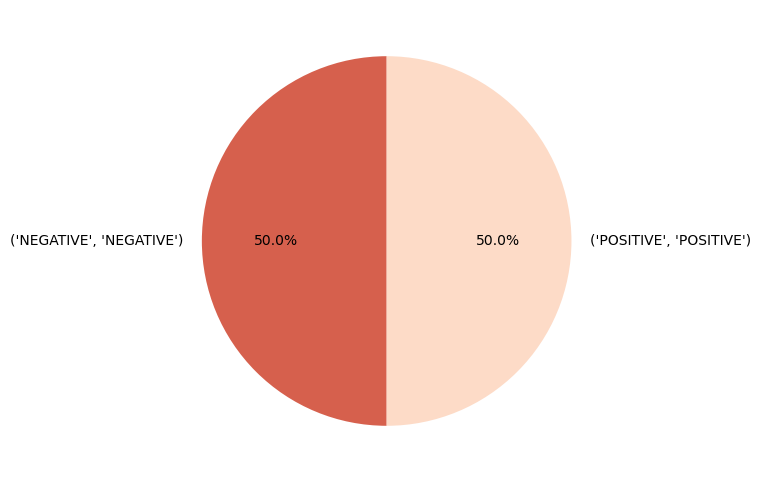

In [81]:
# Distribution of Target Variable
df_target_dist=df.groupby('target_str')

with sns.color_palette("RdBu",4):
    plt.figure(figsize=(14,6))
    labels = df_target_dist['target_str'].value_counts().index
    plt.pie(df_target_dist['target_str'].value_counts(), labels= labels, startangle=90, autopct='%.1f%%')
    plt.show()

/var/folders/13/ts743l9s68547pd3v1mkd3d80000gn/T/ipykernel_2794/1925061017.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a=sns.histplot([len(s) for s in df.tweet_text], bins=50, palette='Set1')


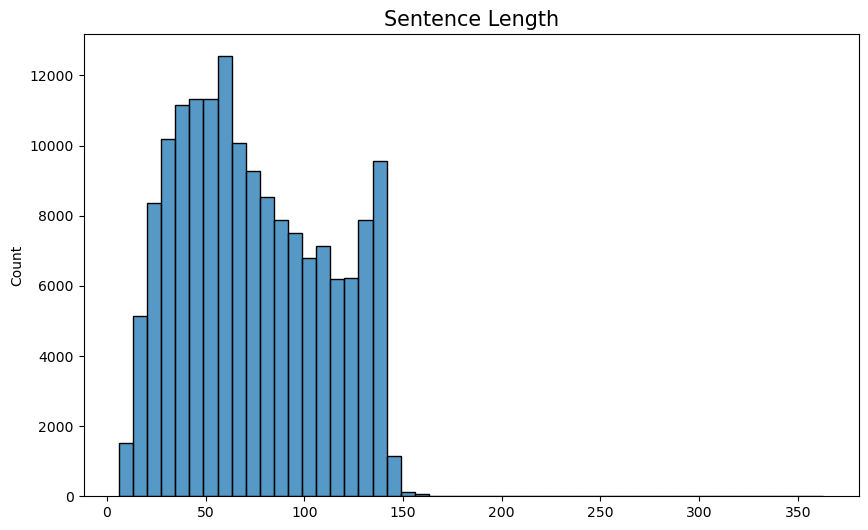

In [82]:
# Length of Tweets
#plot hist of sentence length
plt.figure(figsize=(10, 6))
a=sns.histplot([len(s) for s in df.tweet_text], bins=50, palette='Set1')
a.set_title("Sentence Length",fontsize=15)
plt.show()

/var/folders/13/ts743l9s68547pd3v1mkd3d80000gn/T/ipykernel_2794/2146942849.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a=sns.histplot((df['tweet_text'].str.split().map(lambda x: len(x))), bins=50, palette='Set1')


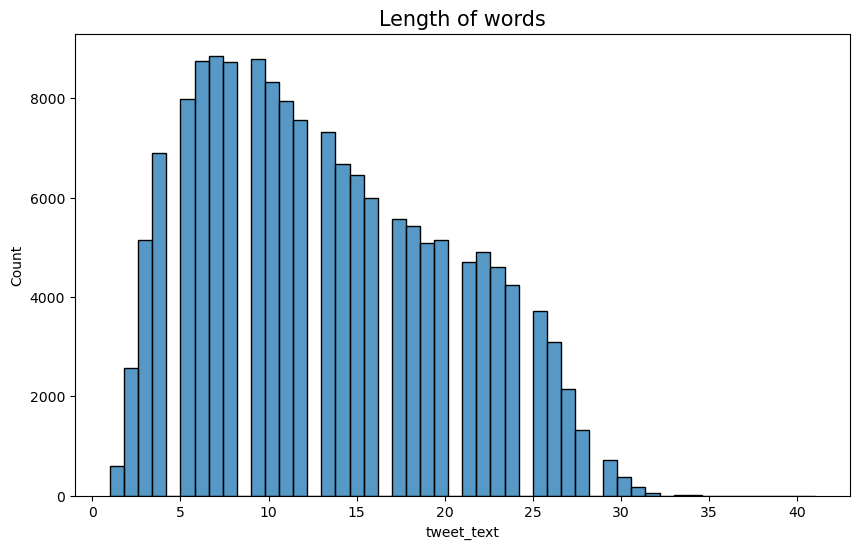

In [83]:
# Length of Words
#plot hist of sentence length
plt.figure(figsize=(10, 6))
a=sns.histplot((df['tweet_text'].str.split().map(lambda x: len(x))), bins=50, palette='Set1')
a.set_title("Length of words",fontsize=15)
plt.show()

In [84]:
df.columns

Index(['sentiment_label', 'tweet_text', 'target_str'], dtype='object')

In [85]:
# Data Cleaning and Feature Engineering
#replacing
df.sentiment_label=np.where(df.sentiment_label == 4, 1, 0) 

In [86]:
# Data Cleaning 
def tweet_clean(tweet):
    tweet = re.sub(r'@[A-Za-z0-9]+'," ",tweet)            #Removing the usernames
    tweet = re.sub(r'^[A-Za-z0-9.!?]+'," ",tweet)         #Removing digits and punctuations
    tweet = re.sub(r'https?://[A-Za-z0-9./]+'," ",tweet)  #Removing link
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)            #convert "#topic" to just "topic"
    #tweet = re.sub(r"\'s", " ", tweet)
    tweet = re.sub(r"\'ve", " have ", tweet)
    #tweet = re.sub(r"n't", " not ", tweet)
    tweet = re.sub(r"\'d", " would ", tweet)
    tweet = re.sub(r"\'ll", " will ", tweet)
    tweet = tweet.lower()
    tweet = tweet.strip('. .')
    tweet = tweet.replace('.',' ')
    tweet = tweet.replace('?',' ')
    tweet = tweet.replace(',',' ')
    tweet = tweet.replace('-',' ')
    tweet = re.sub('[\s]+', ' ', tweet)                   #Correct all multiple white spaces to a single white space
    tweet = tweet.replace("’", "'").replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")
    tweet = tweet.replace("won't", "will not").replace("can't", "can not")
    tweet = tweet.replace("will not", "willnot").replace("can not", "cannot")
    tweet = tweet.replace("€", " euro ")
    tweet = tweet.replace("don't", "dont").replace("do not", "dont").replace("didn't", "didnot").replace("it's", "it is").replace("did not", "didnot")
    tweet = tweet.replace(",000,000", "m").replace("n't", " not").replace("what's", "what is")
    tweet = tweet.replace(",000", "k").replace("i'm", "i am").replace("'re", " are")
    tweet = tweet.replace("he's", "he is").replace("she's", "she is").replace("'s", " own")
    
    return tweet

df.tweet_text = df.tweet_text.apply(lambda x: tweet_clean(x))

In [87]:
df.head(10)

,sentiment_label,tweet_text,target_str
0,1,hey dear happy friday to you already had your ...,POSITIVE
1,1,layin downnnn waiting for zeina to cook breakfast,POSITIVE
2,0,i reckon he will play even if he is not 100 pe...,NEGATIVE
3,0,i know! saw it on the news!,NEGATIVE
4,0,sad that has closed down one of the few web se...,NEGATIVE
5,0,who sings 'i remember' i alwaysss hear it on r...,NEGATIVE
6,1,god on ur side anything is possible,POSITIVE
7,0,why being stupid,NEGATIVE
8,0,delved back into the guts of expression engine...,NEGATIVE
9,0,awww take him with you!,NEGATIVE


In [88]:
# Stopwords and Stemming
nltk.download('stopwords')
stop_words=set(stopwords.words('english'))
stemmer=SnowballStemmer('english')

def preprocess(text, stem=False):
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

df.tweet_text = df.tweet_text.apply(lambda x: preprocess(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/laminjatta/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [89]:
# Removing Small Words
def smallwords(text):
    tokens = []
    for token in text.split():
        if len(token)>2:
            tokens.append(token)
    return " ".join(tokens)

df.tweet_text = df.tweet_text.apply(lambda x: smallwords(x))

In [90]:
df.head()

,sentiment_label,tweet_text,target_str
0,1,hey dear happy friday already rice bowl lunch,POSITIVE
1,1,layin downnnn waiting zeina cook breakfast,POSITIVE
2,0,reckon play even 100 percent know nothing!! wi...,NEGATIVE
3,0,know! saw news!,NEGATIVE
4,0,sad closed one web services used years,NEGATIVE


In [91]:
# Most Frequent Words in Positive and Negative Tweets
# Spliting dataset to negatives and positives for EDA
negatives=df['sentiment_label']==0
positives=df['sentiment_label']==1

# Number of words for each tweet
df['No_of_Words']=[len(text.split()) for text in df['tweet_text']]

In [92]:
df['Words'] = df['tweet_text'].apply(lambda x:str(x).split())

top_pos = Counter([word for text in df[positives]['Words'] for word in text])
top_pos_df=pd.DataFrame(top_pos.most_common(100),columns=['Words','Counts'])

top_neg = Counter([word for text in df[negatives]['Words'] for word in text])
top_neg_df=pd.DataFrame(top_neg.most_common(100),columns=['Words','Counts'])

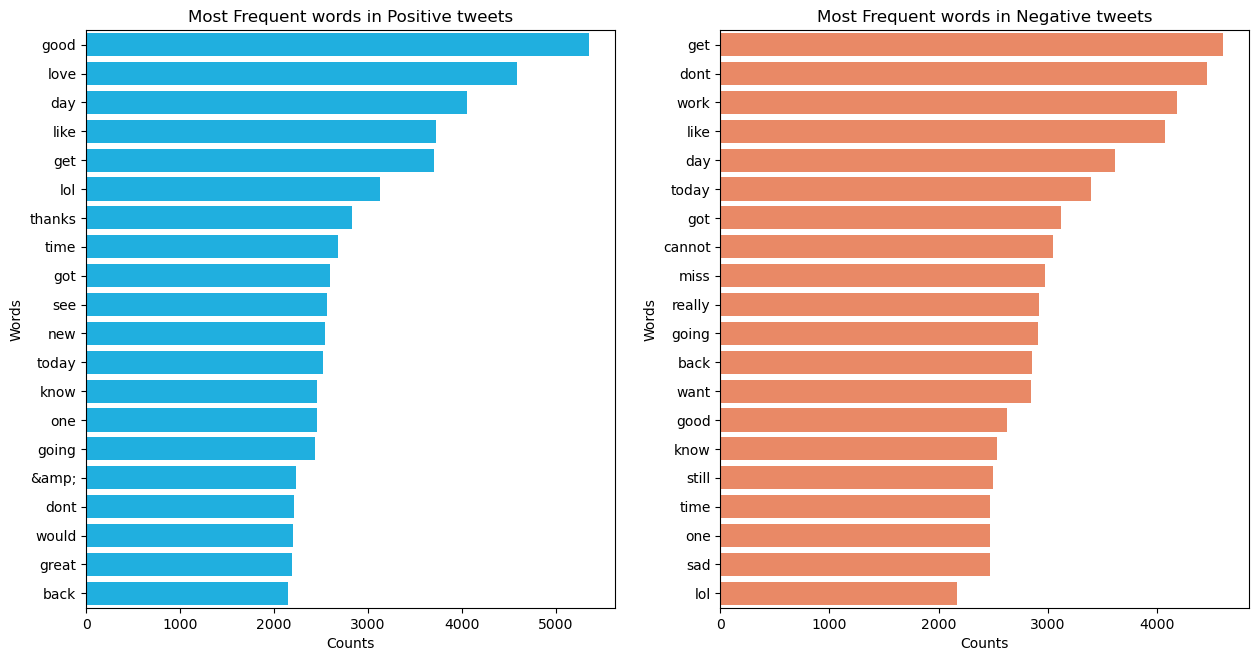

In [93]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,7.5))
sns.barplot(y='Words',x='Counts',data=top_pos_df[:20],color='deepskyblue',ax=ax[0])
sns.barplot(y='Words',x='Counts',data=top_neg_df[:20],color='coral',ax=ax[1])
ax[0].set_title("Most Frequent words in Positive tweets")
ax[1].set_title("Most Frequent words in Negative tweets")
plt.show()

In [94]:
# N-grams
df_pos=df[df['sentiment_label']==1]
df_neg=df[df['sentiment_label']==0]

## visualising top n-grams

def get_top_word_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_word_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

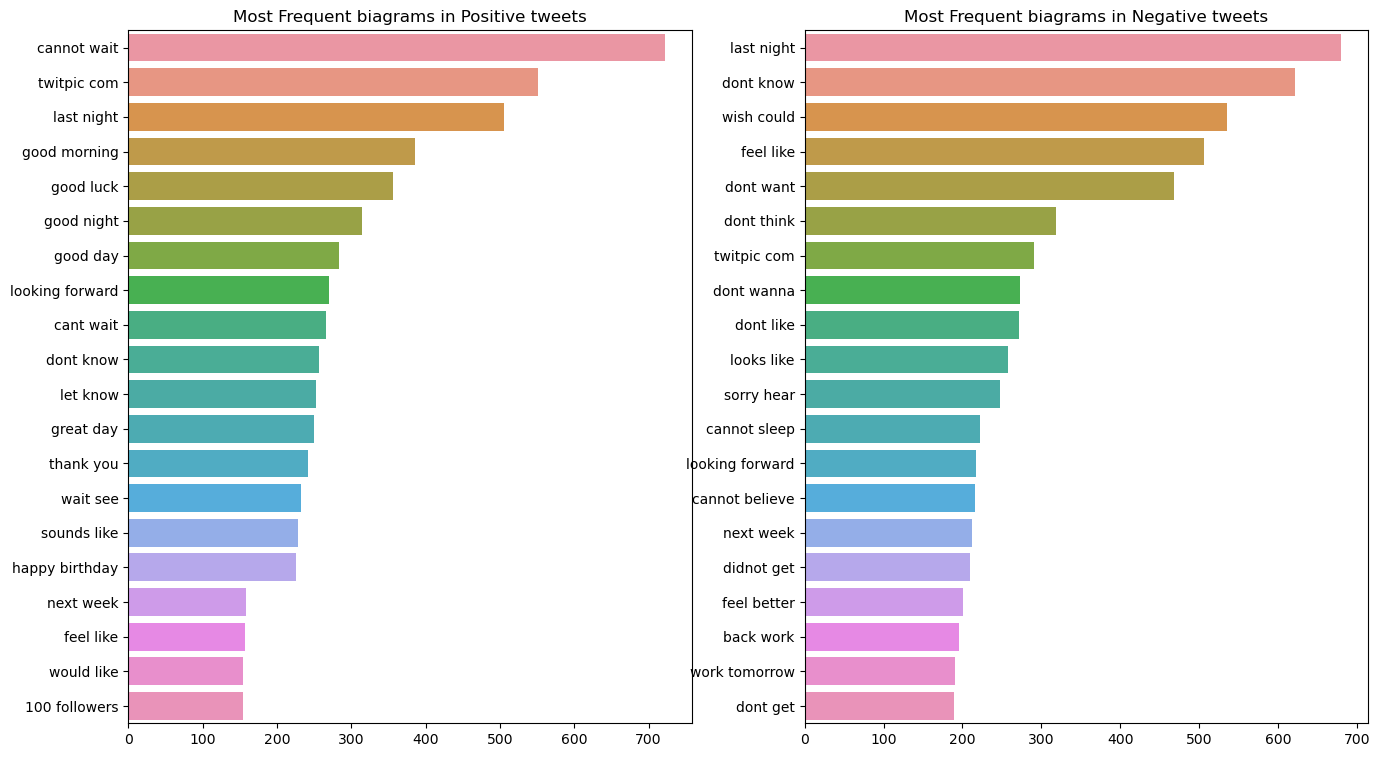

In [95]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(16,9))
top_tweet_bigrams_pos=get_top_word_bigrams(df_pos['tweet_text'])[:20]
x,y=map(list,zip(*top_tweet_bigrams_pos))
sns.barplot(x=y,y=x,ax=ax[0])
top_tweet_bigrams_neg=get_top_word_bigrams(df_neg['tweet_text'])[:20]
x,y=map(list,zip(*top_tweet_bigrams_neg))
sns.barplot(x=y,y=x,ax=ax[1])
ax[0].set_title("Most Frequent biagrams in Positive tweets")
ax[1].set_title("Most Frequent biagrams in Negative tweets")
plt.show()

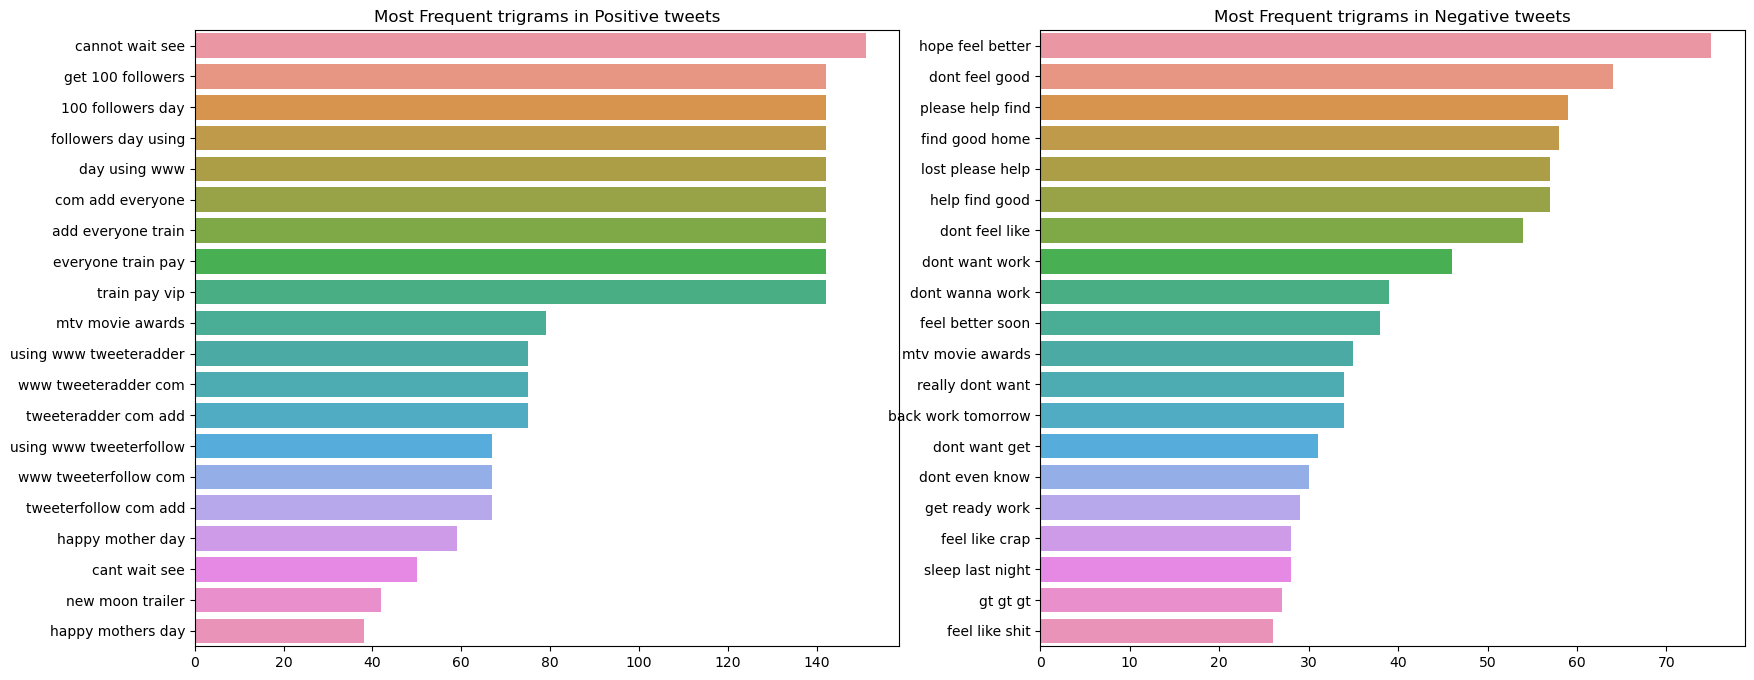

In [96]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,8))
top_tweet_trigrams_pos=get_top_word_trigrams(df_pos['tweet_text'])[:20]
x,y=map(list,zip(*top_tweet_trigrams_pos))
sns.barplot(x=y,y=x,ax=ax[0])
top_tweet_trigrams_neg=get_top_word_trigrams(df_neg['tweet_text'])[:20]
x,y=map(list,zip(*top_tweet_trigrams_neg))
sns.barplot(x=y,y=x,ax=ax[1])
ax[0].set_title("Most Frequent trigrams in Positive tweets")
ax[1].set_title("Most Frequent trigrams in Negative tweets")
plt.show()

In [97]:
df

,sentiment_label,tweet_text,target_str,No_of_Words,Words
0,1,hey dear happy friday already rice bowl lunch,POSITIVE,8,"[hey, dear, happy, friday, already, rice, bowl..."
1,1,layin downnnn waiting zeina cook breakfast,POSITIVE,6,"[layin, downnnn, waiting, zeina, cook, breakfast]"
2,0,reckon play even 100 percent know nothing!! wi...,NEGATIVE,9,"[reckon, play, even, 100, percent, know, nothi..."
3,0,know! saw news!,NEGATIVE,3,"[know!, saw, news!]"
4,0,sad closed one web services used years,NEGATIVE,7,"[sad, closed, one, web, services, used, years]"
...,...,...,...,...,...
159995,0,panera studying &quot;mock&quot; board exams t...,NEGATIVE,7,"[panera, studying, &quot;mock&quot;, board, ex..."
159996,0,control tonight slept wink,NEGATIVE,4,"[control, tonight, slept, wink]"
159997,1,take pride,POSITIVE,2,"[take, pride]"
159998,1,work,POSITIVE,1,[work]


In [98]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [99]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    Y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(Y_test, Y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(Y_test, Y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

## Logistic regression

Accuracy: 0.7545208333333333
XGB Confusion Matrix:
[[17517  6483]
 [ 5300 18700]]
              precision    recall  f1-score   support

           0       0.77      0.73      0.75     24000
           1       0.74      0.78      0.76     24000

    accuracy                           0.75     48000
   macro avg       0.76      0.75      0.75     48000
weighted avg       0.76      0.75      0.75     48000



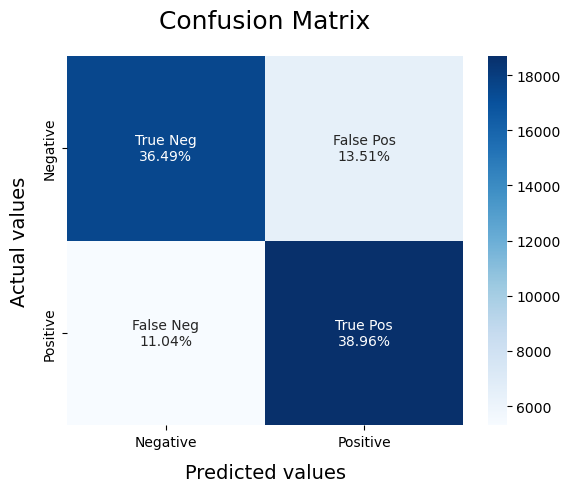

In [106]:

# Preprocess data
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['tweet_text'])
y = df['sentiment_label']

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3)

# Train logistic regression model
lr = LogisticRegression()
lr.fit(X_train, Y_train)

# Evaluate model on testing set
Y_pred = lr.predict(X_test)
acc_lr = accuracy_score(Y_test, Y_pred)
print('Accuracy:', acc_lr)

# Create confusion matrix
cm_lr = confusion_matrix(Y_test, Y_pred)
print('XGB Confusion Matrix:')
print(cm_lr)

model_Evaluate(lr)


## XGBoost

In [101]:
from xgboost import XGBClassifier

Accuracy: 0.7225208333333333
Confusion Matrix:
[[14833  9158]
 [ 4161 19848]]
              precision    recall  f1-score   support

           0       0.78      0.62      0.69     23991
           1       0.68      0.83      0.75     24009

    accuracy                           0.72     48000
   macro avg       0.73      0.72      0.72     48000
weighted avg       0.73      0.72      0.72     48000



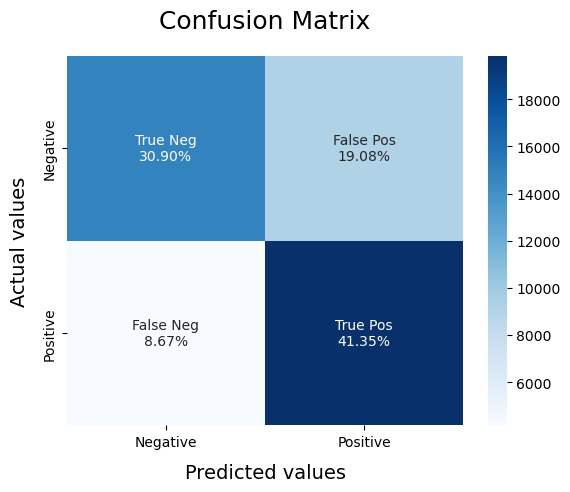

In [102]:
# Train XGBoost model
xgb = XGBClassifier()
xgb.fit(X_train, Y_train)

# Evaluate model on testing set
Y_pred = xgb.predict(X_test)
acc_xgb = accuracy_score(Y_test, Y_pred)
print('Accuracy:', acc_xgb)

# Create confusion matrix
cm_xgb = confusion_matrix(Y_test, Y_pred)
print('XGB Confusion Matrix:')
print(cm_xgb)

model_Evaluate(xgb)


## Random forest

In [103]:
from sklearn.ensemble import RandomForestClassifier

Accuracy: 0.7439166666666667
Confusion Matrix:
[[17965  6026]
 [ 6266 17743]]
              precision    recall  f1-score   support

           0       0.74      0.75      0.75     23991
           1       0.75      0.74      0.74     24009

    accuracy                           0.74     48000
   macro avg       0.74      0.74      0.74     48000
weighted avg       0.74      0.74      0.74     48000



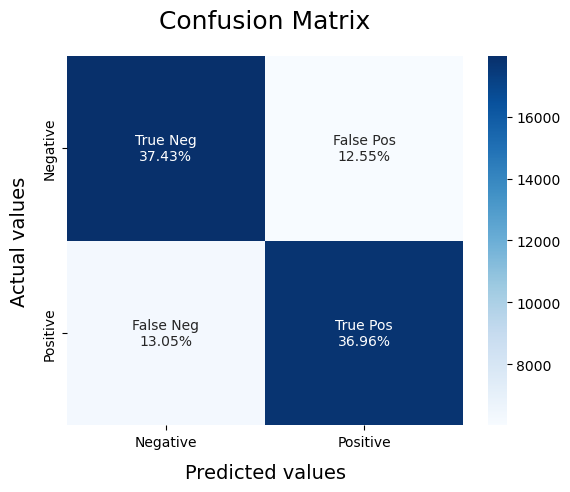

In [104]:
%%time
# Train Random Forest model
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train, Y_train)

# Evaluate model on testing set
Y_pred = rf.predict(X_test)
acc_rf = accuracy_score(Y_test, Y_pred)
print('Accuracy:', acc_rf)

# Create confusion matrix
cm_rf = confusion_matrix(Y_test, Y_pred)
print('Random Forest Confusion Matrix:')
print(cm_rf)

model_Evaluate(rf)


# Comparison

In [105]:
# Print results
print('Logistic Regression Accuracy:', acc_lr)
print('Logistic Regression Confusion Matrix:')
print(cm_lr)

print('XGBoost Accuracy:', acc_xgb)
print('XGBoost Confusion Matrix:')
print(cm_xgb)

print('Random Forest Accuracy:', acc_rf)
print('Random Forest Confusion Matrix:')
print(cm_rf)


Logistic Regression Accuracy: 0.7562916666666667
Logistic Regression Confusion Matrix:
[[17471  6520]
 [ 5178 18831]]
XGBoost Accuracy: 0.7225208333333333
XGBoost Confusion Matrix:
[[14833  9158]
 [ 4161 19848]]
Random Forest Accuracy: 0.7439166666666667
Random Forest Confusion Matrix:
[[17965  6026]
 [ 6266 17743]]
